<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'cpu'


dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 199
shape of p(z,x,t) = (200, 200, 800)


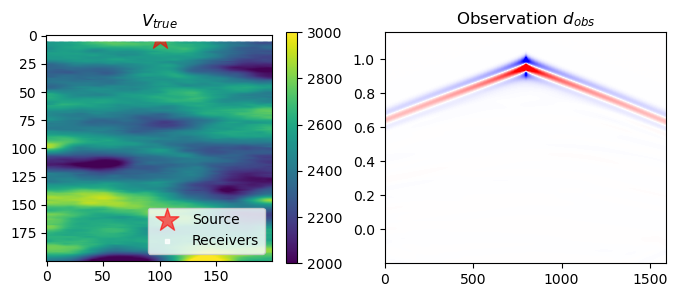

In [5]:
# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

v_ref, Q = gaussian2d(ranges=[100,20],variance=300,nx=[nz,nx],param=1,mean=2500)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)
d_obs = p[zxrec[0], zxrec[1], :]


plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[az[0], az[-1],at[0], at[-1]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [11]:
# Set initial velocity guess
v_init = np.zeros([nz, nx]) + 2500

# Display initial gradiant
'''plt.figure(figsize=(3,3))
g_adj = gradiant(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
plt.imshow(g_adj)
plt.colorbar() 
plt.title("Adjoint State gradiant")'''

# mu = np.mean(v_ref)
mu = 2500
alpha = 0.01 # Regularization parameter

# Define cost function
def cost(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	# J: Prior part
	loss_J = J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	v = vel.flatten()-mu
	penalty = .5 * v.T.dot(Q.toarray()).dot(v) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	return loss

def gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	nz, nx, nt = len(az), len(ax), len(at)
	if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,vel,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten() + Q.toarray().dot((vel-mu).flatten()) * alpha

# cost(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

In [12]:
# minimize cost function
start = time.time()
resi = minimize(fun = cost, 
               x0 = v_init.flatten(), 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':200}
              )
v_fwi = np.reshape(resi.x,(nz,nx))
print(v_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 3771.9065 Penalty term = 0.0000 Total loss = 3771.9065 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        40000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77191D+03    |proj g|=  2.48934D-01
Loss (J) = 3767.9507 Penalty term = 0.0001 Total loss = 3767.9508 

At iterate    1    f=  3.76795D+03    |proj g|=  2.47107D-01
Loss (J) = 657.5810 Penalty term = 28513.5875 Total loss = 29171.1685 
Loss (J) = 3156.3869 Penalty term = 230.8122 Total loss = 3387.1990 

At iterate    2    f=  3.38720D+03    |proj g|=  5.36616D+00
Loss (J) = 924.8909 Penalty term = 115.8957 Total loss = 1040.7867 

At iterate    3    f=  1.04079D+03    |proj g|=  5.99553D-01
Loss (J) = 752.7537 Penalty term = 264.5241 Total loss = 1017.2778 
Loss (J) = 845.8676 Penalty term = 128.2129 Total loss = 974.0805 

At iterate    4    f=  9.74081D+02    |proj g|=  6.72455D-01
Loss (J) = 745.6421 Penalty term = 145.5740 To

KeyboardInterrupt: 

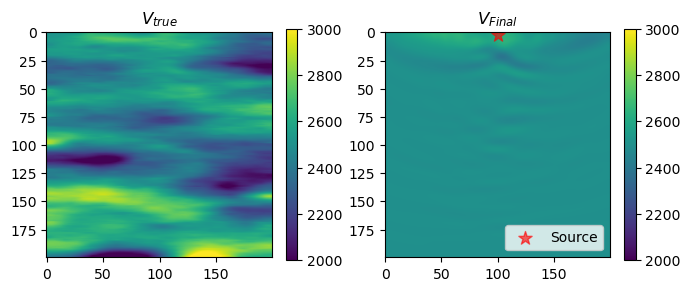

In [14]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(v_fwi,vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{Final}$")
plt.show()

In [10]:
v = v_fwi.flatten()-mu
.5 * v.T.dot(Q.toarray()).dot(v)

1859.203310115319